# Bio-realistic Model of a Mouse V1 Cortical Column

This tutorial will run through the steps to run the Allen Institute V1 cortical column model from Billeh et al. 2020. The model consists of two main components - filterNet, a model of LGN that behaves like a spatiotemporal filter and proccesses visual stimuli to provide input to V1, and the pointNet model of the V1 cortical column. PointNet models each neuron as simplified single compartment, with a small number of parameters, which greatly reduces simulation time while maintaining similar performance results compared to more detailed models (see [Teeter et al., 2018](https://www.nature.com/articles/s41467-017-02717-4) for details on the GLIF models used here, and [Billeh et al., 2020](https://www.cell.com/neuron/fulltext/S0896-6273(20)30067-2?dgcid=raven_jbs_etoc_email) for comparison of PointNet with a more detailed version of the V1 cortical column model).

This tutorial will cover the following topics:

- How to set up and run the LGN and V1 models
- How to provide different visual stimuli to the models
- How to visualize and analyze the simulation results
- How to set up a large batch of simulations efficiently



In [1]:
import matplotlib.pyplot as plt
import os
import pathlib
import numpy as np
import pandas as pd

The instructions for each simulation are contained in the configuration (config) file. Instructions include information such as the duration of the simulation, the timestep, and the locations of the parameter files for each cell and edge within the model. We recommend looking through the configuration file to understand how BMTK interacts with each component of the model. You can find the configuration files at the file locations listed below. 

For more information on editing the configuration files, please see our [website](link) and the [SONATA documentation](link).


In [2]:
filternet_config = 'filternet_configs/config.filternet.dg.2Hz.270deg.json'
pointnet_config = 'v1_point_config/config.json'

This notebook provides instructions and code to run filterNet, but be aware that the simulation will take approximately 40 minutes. We include a few trials of pre-run FilterNet results to accelerate progress through the notebook and recommend leaving the FilterNet section commented-out the first time you run the notebook.

In [3]:
#from run_filternet import run as run_filternet

#run_filternet(filternet_config)

The V1 model consists of 230,924 cells divided into 5 layers (L1, L2/3, L4, L5, L6). Each layer includes four main cell types - excitatory neurons, and three inhibitory subtypes: PV, SST, and Htr3a (the inhibitory subtype which includes VIP cells).

The cortical column has a radius of 400 microns. If we modelled only neurons within the 400 micron radius, due to the spatially-organized connectivity between neurons in the model, neurons at the edge of the 400 micron radius would receive less input than the neurons closer to the center. We instead model an additional 445 micron radius to provide input to the neurons at the edge of the cortical column. We will ignore these additional neurons when we analyze the simulation results later. 

For more information on the model, please see [Billeh et al., 2020](https://www.cell.com/neuron/fulltext/S0896-6273(20)30067-2?dgcid=raven_jbs_etoc_email).

In [4]:
from run_pointnet import main as run_pointnet

run_pointnet(pointnet_config)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Apr  7 2025 08:15:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2025-06-03 18:17:54,401 [INFO] Created log file
2025-06-03 18:17:55,485 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:17:55,587 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:17:55,618 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:18:04,004 [INFO] Setting up output directory
2025-06-03 18:18:04,005 [INFO] Building cells.
2025-06-03 18:18:08,488 [INFO] Building recurrent connections
2025-06-03 18:18:46,929 [INFO] Network created.
2025-06-03 18:18:46,931 [INFO] Build virtual cell stimulations for LGN_spikes
2025-06-03 18:18:55,541 [INFO] Build virtual cell stimulations for BKG_spikes
2025-06-03 18:18:58,822 [INFO] Starting Simulation
2025-

We can now visualize the results of our simulation. BMTK includes some functions to visualize results of the simulation. 

We signify that this is the 'full' version of the model, with the 400 micron core and 800 micron surrounding annulus. We also want to sort by the tuning angle of each cell, to better visualize the range in responses from differently-tuned cells to the 270 degrees drifting grating.

Finally, recall that we only want to view the activity of the neurons within 400 micrometers of the center of the column.

After plotting the figure, we save the results.

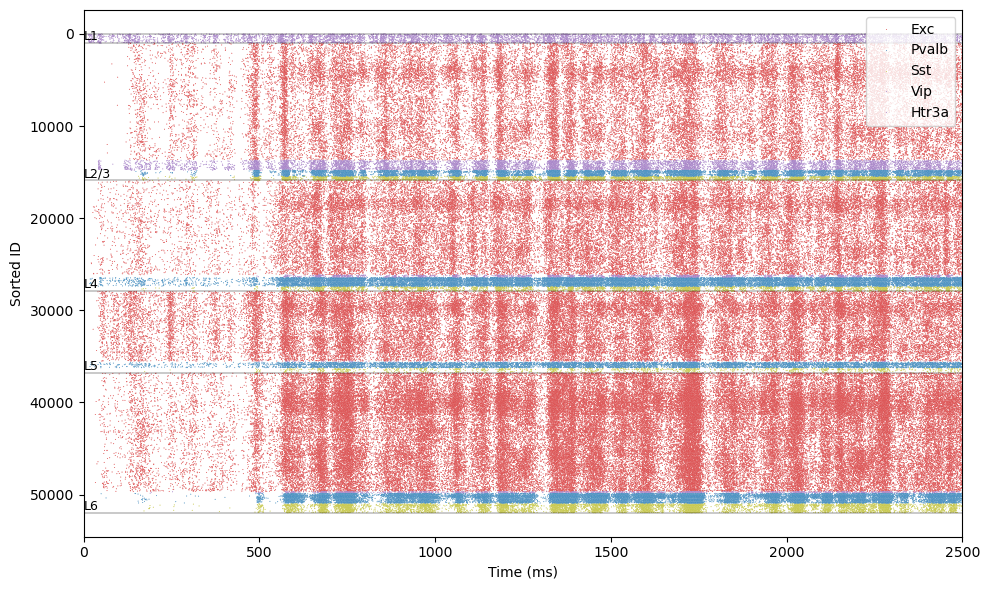

In [5]:
import plotting_utils as pu

pointnet_config = 'output/config.json'
net = 'full'
sortby='tuning_angle'
radius = 400.0

plt.figure(figsize=(10, 6))


ax = pu.plot_raster(pointnet_config, sortby=sortby, **pu.settings[net])
ax.set_xlim([0, 2500])
plt.tight_layout()
config_folder = os.path.dirname(pointnet_config)
plt.savefig(f"{config_folder}/raster_by_{sortby}.png", dpi=300)

Let's load the simulation results so that we can perform additional analyses on the data:

In [6]:
spikes_df, hue_order, color_dict, layer_divisions = pu.make_figure_elements(pointnet_config, radius, sortby)

In [7]:
spikes_df.head()

timestamps population  Sorted ID Cell Type  Tuning Angle layer
node_ids                                                                
168740       1049.75         v1      33780       Exc     97.793457     5
168740        952.50         v1      33780       Exc     97.793457     5
168740        842.50         v1      33780       Exc     97.793457     5
168740        741.75         v1      33780       Exc     97.793457     5
168740        669.50         v1      33780       Exc     97.793457     5

First, let's verify that the firing rates of each population are realistic. 

Let's compute the firing rates during the 2.5 seconds of the drifting grating presentation. 

In [8]:
# calculate firing rates
rates = spikes_df[spikes_df['timestamps']>500.0].groupby(['Sorted ID'])['timestamps'].count()/2.5
rates = rates.reset_index(name = 'Mean Rate')
rates_df = spikes_df[['population', 'Sorted ID', 'Cell Type', 'Tuning Angle', 'layer']].drop_duplicates('Sorted ID')
rates_df = rates_df.merge(rates, how='left', left_on='Sorted ID', right_on = 'Sorted ID')


<Axes: xlabel='layer', ylabel='Mean Rate'>

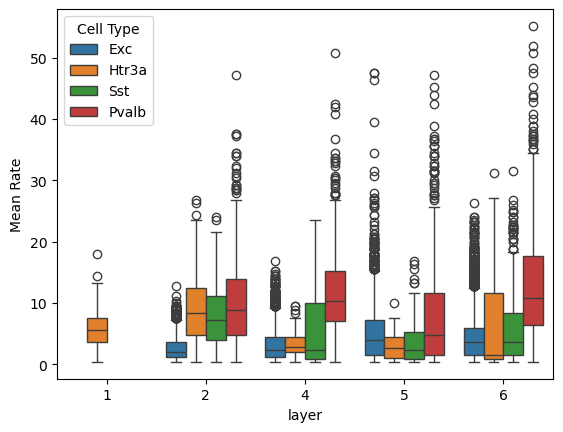

In [9]:
import seaborn as sns
order = [1, 2, 4, 5, 6]
sns.boxplot(rates_df, x='layer', y='Mean Rate', hue='Cell Type', order=order)

Provide figure with neuropixels firing rates here? Or include data?

Next, let's compute the response to each tuning angle, to verify that the neurons selective for 270 degrees are most responsive to the 270 degree drifting grating.

In [10]:
angles_list = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0, 360.0]
rates_df['Tuning Angle'] = rates_df['Tuning Angle'].round()
rates_df = rates_df[rates_df['Tuning Angle'].isin(angles_list)]

In [11]:
rates_df

population  Sorted ID Cell Type  Tuning Angle layer  Mean Rate
19            v1      33615       Exc          90.0     5        8.4
50            v1      32663       Exc          45.0     5        6.8
57            v1      31726       Exc           0.0     5        6.0
106           v1      34562       Exc         135.0     5        6.4
130           v1      27940       Exc         180.0     5        3.6
...          ...        ...       ...           ...   ...        ...
38888         v1      21015       Exc         360.0     4        4.0
38929         v1      24876       Exc         135.0     4        1.6
38970         v1      17193       Exc         225.0     4        2.8
38971         v1      17175       Exc         225.0     4        3.6
39064         v1      26148       Exc         180.0     4        4.4

[827 rows x 6 columns]

<Axes: xlabel='Tuning Angle', ylabel='Mean Rate'>

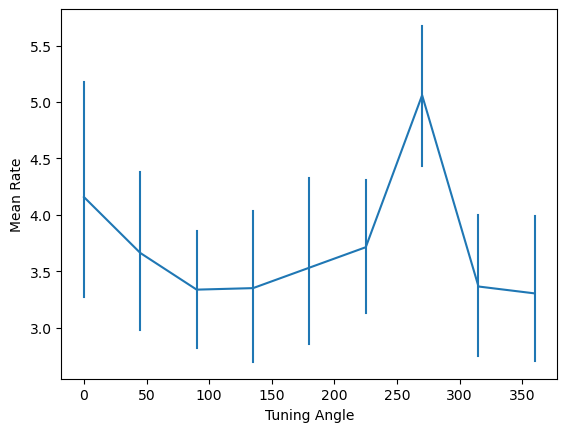

In [12]:
sns.lineplot(rates_df[rates_df['Cell Type']=='Exc'], x='Tuning Angle', y='Mean Rate', err_style='bars')

Exercise: If you wanted to visualize which layer responded the most to the drifting grating, how would you edit the above code?

<Axes: xlabel='Tuning Angle', ylabel='Mean Rate'>

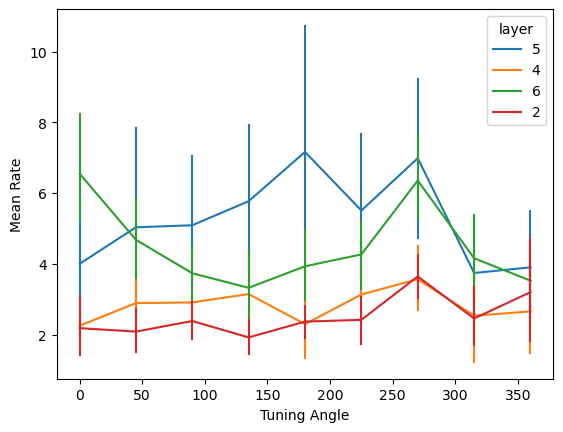

In [13]:
sns.lineplot(rates_df[rates_df['Cell Type']=='Exc'], x='Tuning Angle', y='Mean Rate', hue = 'layer', err_style='bars')

## Providing different visual stimuli to FilterNet

Please see documentation here.

We've pre-run FilterNet with the desired stimulus already. 

In [14]:
pointnet_config_movie = 'v1_point_config/config.movie.json'
run_pointnet(pointnet_config_movie)

2025-06-03 18:23:47,016 [INFO] Created log file
2025-06-03 18:23:47,624 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:23:47,663 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:23:47,669 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:23:51,721 [INFO] Setting up output directory
2025-06-03 18:23:51,724 [INFO] Building cells.
2025-06-03 18:23:56,340 [INFO] Building recurrent connections
2025-06-03 18:24:18,146 [INFO] Network created.
2025-06-03 18:24:18,148 [INFO] Build virtual cell stimulations for LGN_spikes
2025-06-03 18:24:24,926 [INFO] Build virtual cell stimulations for BKG_spikes
2025-06-03 18:24:26,887 [INFO] Starting Simulation
2025-06-03 18:28:25,251 [INFO] Simulation finished, finalizing results.
2025-06-03 18:28:28,981 [INFO] Done.


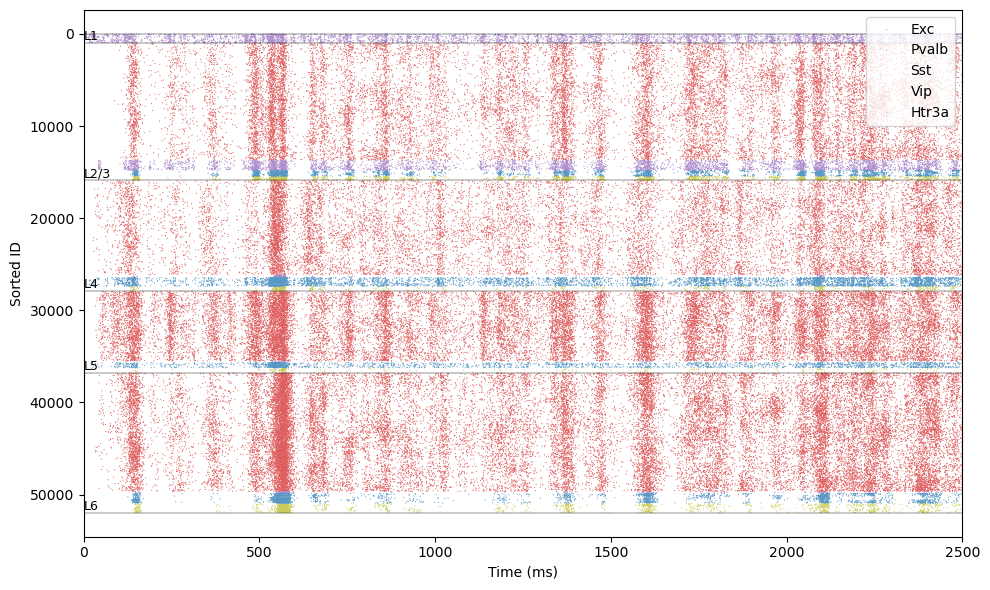

In [15]:
pointnet_config_movie = 'output_movie/config.movie.json'
net = 'full'
sortby='tuning_angle'
radius = 400.0

plt.figure(figsize=(10, 6))


ax = pu.plot_raster(pointnet_config_movie, sortby=sortby, **pu.settings[net])
ax.set_xlim([0, 2500])
plt.tight_layout()
config_folder = os.path.dirname(pointnet_config_movie)
plt.savefig(f"{config_folder}/raster_by_{sortby}.png", dpi=300)

Let's test the response to a full-field flash. This stimulus is useful to test the stability of a network.

In [16]:
pointnet_config_flash = 'v1_point_config/config.fullfield_250ms.json'
run_pointnet(pointnet_config_flash)

2025-06-03 18:28:32,746 [INFO] Created log file


2025-06-03 18:28:33,364 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:28:33,409 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:28:33,417 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:28:42,867 [INFO] Setting up output directory
2025-06-03 18:28:42,870 [INFO] Building cells.
2025-06-03 18:28:47,578 [INFO] Building recurrent connections
2025-06-03 18:29:23,751 [INFO] Network created.
2025-06-03 18:29:23,753 [INFO] Build virtual cell stimulations for LGN_spikes
2025-06-03 18:29:31,150 [INFO] Build virtual cell stimulations for BKG_spikes
2025-06-03 18:29:33,144 [INFO] Starting Simulation
2025-06-03 18:33:31,699 [INFO] Simulation finished, finalizing results.
2025-06-03 18:33:36,033 [INFO] Done.


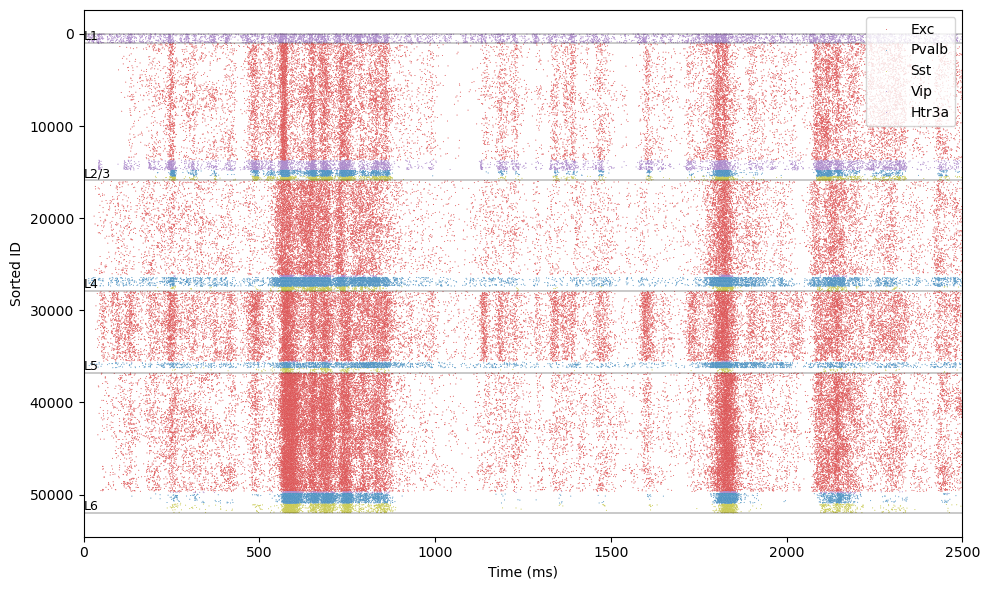

In [17]:
pointnet_config_flash = 'output_flash/config.fullfield_250ms.json'
net = 'full'
sortby='tuning_angle'
radius = 400.0

plt.figure(figsize=(10, 6))


ax = pu.plot_raster(pointnet_config_flash, sortby=sortby, **pu.settings[net])
ax.set_xlim([0, 2500])
plt.tight_layout()
config_folder = os.path.dirname(pointnet_config_flash)
plt.savefig(f"{config_folder}/raster_by_{sortby}.png", dpi=300)

## How to silence a population of cells

We can test the contribution of each cell type to the results by silencing he population.

Let's start with silencing PV neurons in the model. We will first get the node ID of each PV (or Pvalb) neuron in the V1 network to tell the simulator which nodes to silence. 

In [18]:
PV_node_ids = spikes_df[spikes_df['Cell Type']=='Pvalb'].reset_index()['node_ids'].drop_duplicates().sort_values()

We will now make a new configuration file with added instructions to provide a strong inhibitory current to all PV neurons in the model. For convenience, we will use the configuration file from our first drifting grating simulation as a template. Additional documentation on providing a current clamp stimulus to the model is available on the [BMTK website](https://alleninstitute.github.io/bmtk/current_clamps.html).

In [19]:
import json 

config_template = 'v1_point_config/config.json'

config_js = json.load(open(config_template))

# create a new output directory
output_dir = 'output_PV_clamp'
os.makedirs(output_dir, exist_ok=True)

config_js["manifest"]["$OUTPUT_DIR"] = output_dir
config_js["inputs"]["current_clamp"] = {}
config_js["inputs"]["current_clamp"]["module"] = "IClamp"
config_js["inputs"]["current_clamp"]["input_type"] = "current_clamp"
config_js["inputs"]["current_clamp"]["node_set"] = PV_node_ids.to_list()
config_js["inputs"]["current_clamp"]["amp"] = -500.0 # pA
config_js["inputs"]["current_clamp"]["delay"] = 500.0 # ms
config_js["inputs"]["current_clamp"]["duration"] = 2500.0 # ms

config_name = 'v1_point_config/config_PV_clamp.json'

json.dump(config_js, open(config_name, "w"), indent = 2)


In [20]:
from run_pointnet import main as run_pointnet

pointnet_config_clamp = 'v1_point_config/config_PV_clamp.json'
run_pointnet(pointnet_config_clamp)

2025-06-03 18:33:39,856 [INFO] Created log file
2025-06-03 18:33:40,439 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:33:40,477 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:33:40,483 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:33:44,734 [INFO] Setting up output directory
2025-06-03 18:33:44,737 [INFO] Building cells.
2025-06-03 18:33:49,760 [INFO] Building recurrent connections
2025-06-03 18:34:11,475 [INFO] Network created.
2025-06-03 18:34:11,478 [INFO] Build virtual cell stimulations for LGN_spikes
2025-06-03 18:34:18,612 [INFO] Build virtual cell stimulations for BKG_spikes
2025-06-03 18:34:20,560 [INFO] Starting Simulation


2025-06-03 18:44:05,957 [INFO] Simulation finished, finalizing results.
2025-06-03 18:44:16,088 [INFO] Done.


Let's plot a raster plot to visualize the results of the simulation:

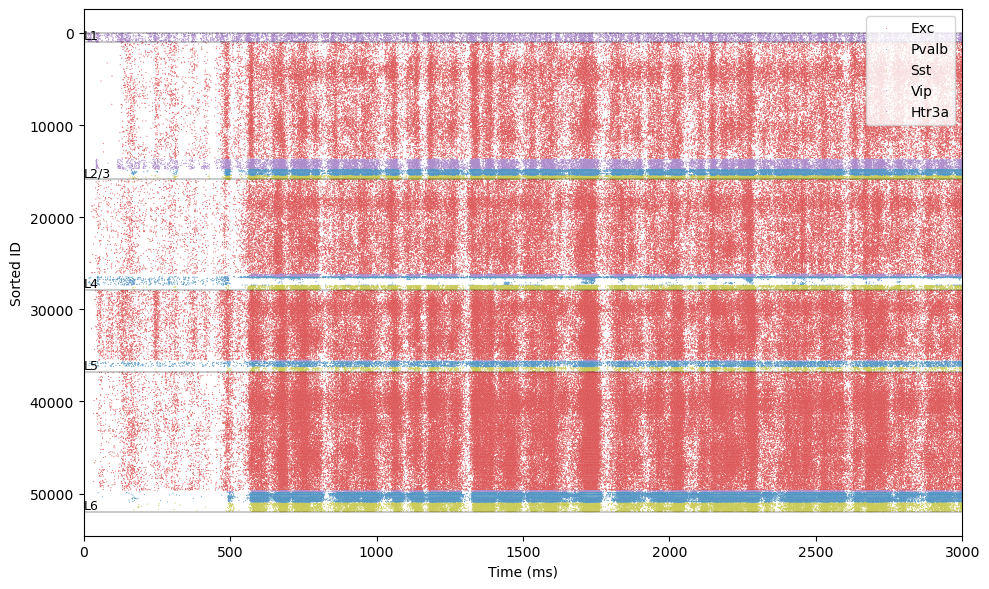

In [21]:
pointnet_config = 'output_PV_clamp/config_PV_clamp.json'
net = 'full'
sortby='tuning_angle'
radius = 400.0

plt.figure(figsize=(10, 6))

ax = pu.plot_raster(pointnet_config, sortby=sortby, **pu.settings[net])
ax.set_xlim([0, 3000])
plt.tight_layout()
config_folder = os.path.dirname(pointnet_config)
plt.savefig(f"{config_folder}/raster_by_{sortby}.png", dpi=300)

Visually, we can tell that silencing all PV neurons has a strong effect on the model output. It would be best scientific practice to run a more analysis of the results of both simulations to form a more thorough understanding of the role of PV cells within the network.

## Additional exercise:
- Compute and compare firing rates between the original simulation and the simulation with silenced PV cells
- Compute and compare direction selectivity between the original simulation and the simulation with silenced PV cells

## How to set up and run a batch of simulations

Let's set up additional simulations to silence each of the other neuron types within the model. We'll use the configuration file we made to silence PV cells as a template and edit the 'node_set' and '$OUTPUT_DIR' values.



In [22]:
cell_types = spikes_df['Cell Type'].unique()
cell_types = np.delete(cell_types, np.argwhere(cell_types == 'Pvalb')) # remove Pvalb from the list of cell types 
# because we already ran a simulation that silenced PV cells


config_template = 'v1_point_config/config_PV_clamp'

for cell_type in cell_types:
    # open the template, edit entries, and run
    clamp_node_ids = spikes_df[spikes_df['Cell Type']==cell_type].reset_index()['node_ids'].drop_duplicates().sort_values()

    output_dir = f'output_{cell_type}_clamp'
    os.makedirs(output_dir, exist_ok=True)

    config_js["manifest"]["$OUTPUT_DIR"] = output_dir
    config_js["inputs"]["current_clamp"]["node_set"] = clamp_node_ids.to_list()
   
    config_name = f'v1_point_config/config_{cell_type}_clamp.json'

    json.dump(config_js, open(config_name, "w"), indent = 2)
        

Check that the new configuration files are in the 'v1_point_config' folder. You should see three new files named 'config_Exc_clamp.json', config_Htr3a_clamp.json', and 'config_Sst_clamp.json'. Within each configuration file, the $OUTPUT_DIR should be unique and the list of nodes to silence should be different as well.

Next, we'll set up a script to run each simulation. Note that the following code will all three simulations, which will take 15-30 minutes.

In [23]:
for cell_type in cell_types:
    run_pointnet(f'v1_point_config/config_{cell_type}_clamp.json')

2025-06-03 18:44:28,186 [INFO] Created log file


2025-06-03 18:44:28,965 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:44:29,009 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:44:29,016 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:44:43,719 [INFO] Setting up output directory
2025-06-03 18:44:43,723 [INFO] Building cells.
2025-06-03 18:44:49,762 [INFO] Building recurrent connections
2025-06-03 18:45:40,299 [INFO] Network created.
2025-06-03 18:45:40,302 [INFO] Build virtual cell stimulations for LGN_spikes
2025-06-03 18:45:48,228 [INFO] Build virtual cell stimulations for BKG_spikes
2025-06-03 18:45:54,565 [INFO] Starting Simulation
2025-06-03 18:55:16,511 [INFO] Simulation finished, finalizing results.
2025-06-03 18:55:22,743 [INFO] Done.
2025-06-03 18:55:22,782 [INFO] Created log file
2025-06-03 18:55:23,454 [INFO] Batch processing nodes for v1/0.
2025-06-03 18:55:23,494 [INFO] Batch processing nodes for lgn/0.
2025-06-03 18:55:23,500 [INFO] Batch processing nodes for bkg/0.
2025-06-03 18:55:32,901 [INFO] S

## Additional Exercise:

- Go through and plot the results for each of the above simulations

## Compute OSI and DSI

A common metric in visual neuroscience is the orientation selectivity index (OSI) and direction selectivity index (DSI) of a population of cells in V1. 

OSI is calculated as:

DSI is calculated as:

We pre-ran the simulations necessary to calculate OSI and DSI for the model in the folder **output_all_directions**. There is model output from 10 trials at 8 different orientations. 


In [24]:
from calculate_metrics_gratings import calculate_metrics_gratings

calculate_metrics_gratings()


Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial0.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial1.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial2.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial3.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial4.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial5.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial6.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial7.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial8.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori0.0_trial9.txt
Calculating Firing Rate
output_all_directions/spikes_driftingGratings_ori45.0_trial0.txt
Calculating Firing Rate
output_

In [25]:
# Plot the results now:
OSI_DSI_df = pd.read_csv('output_all_directions/OSI_DSI_DF.csv', sep = ' ')


# get cell type and layer data from the spikes_df dataframe above
node_df = spikes_df.reset_index()[['node_ids', 'Cell Type', 'layer']].drop_duplicates()
OSI_DSI_df['node_id'] = OSI_DSI_df['node_id'] + spikes_df.reset_index()['node_ids'].min() # align node_ids 
OSI_DSI_df = OSI_DSI_df.merge(node_df, how='left', left_on='node_id', right_on='node_ids')


In [26]:
OSI_DSI_df.head()

node_id       DSI       OSI  preferred_angle  max_mean_rate(Hz)  \
0    20838  0.211513  0.418153            180.0               6.28   
1    20839       NaN       NaN              NaN               0.00   
2    20840  0.163486  0.209076            180.0              10.44   
3    20841  0.093018  0.299440            180.0               4.36   
4    20842       NaN       NaN              NaN               0.00   

   Avg_Rate(Hz)  node_ids Cell Type layer  
0         2.225   20838.0       Exc     5  
1         0.000       NaN       NaN   NaN  
2         5.145   20840.0       Exc     5  
3         2.060   20841.0       Exc     5  
4         0.000   20842.0       Exc     5

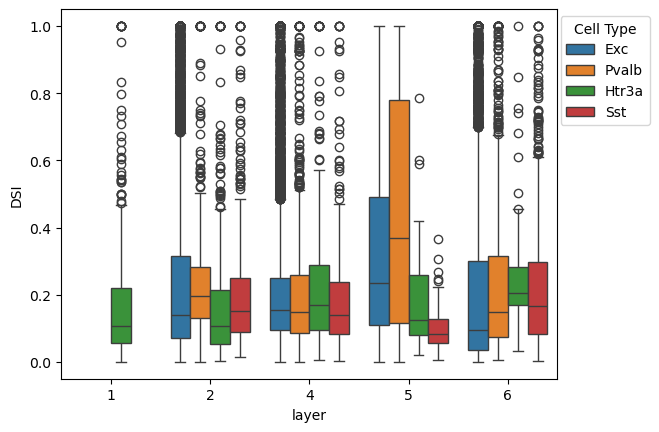

In [27]:
import seaborn as sns
order = ['1', '2', '4', '5', '6']
ax = sns.boxplot(OSI_DSI_df, x='layer', y='DSI', hue='Cell Type', order = order)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2,1))


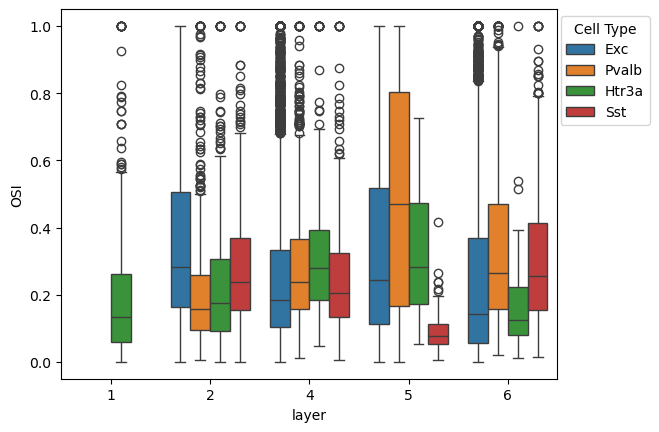

In [28]:
order = ['1', '2', '4', '5', '6']
ax = sns.boxplot(OSI_DSI_df, x='layer', y='OSI', hue='Cell Type', order = order)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2,1))

## Additional Exercises:

- Try silencing a different population
- Try silencing different layers
- Try silencing neurons similarly-tuned or oppositely-tuned populations. Does this affect direction selectivity?
- Try generating the data required to calculate OSI and DSI on your own
